In [6]:
import findspark
import pyspark
findspark.init('C:\spark\spark\spark-2.2.0-bin-hadoop2.7')
session = pyspark.sql.SparkSession.builder.getOrCreate()

session.range(10).collect()

[Row(id=0),
 Row(id=1),
 Row(id=2),
 Row(id=3),
 Row(id=4),
 Row(id=5),
 Row(id=6),
 Row(id=7),
 Row(id=8),
 Row(id=9)]

In [31]:
books=session.read.format("csv").option("header", "true").option("inferscheme", "true").option("sep", ";").load("BX-Books.csv")
users=session.read.format("csv").option("header", "true").option("inferscheme", "true").option("sep", ";").load("BX-Users.csv")
ratings=session.read.format("csv").option("header", "true").option("inferscheme", "true").option("sep", ";").load("BX-Book-Ratings.csv")

In [32]:
#books.show()
books.schema
ratings.show()

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 276725|034545104X|          0|
| 276726|0155061224|          5|
| 276727|0446520802|          0|
| 276729|052165615X|          3|
| 276729|0521795028|          6|
| 276733|2080674722|          0|
| 276736|3257224281|          8|
| 276737|0600570967|          6|
| 276744|038550120X|          7|
| 276745| 342310538|         10|
| 276746|0425115801|          0|
| 276746|0449006522|          0|
| 276746|0553561618|          0|
| 276746|055356451X|          0|
| 276746|0786013990|          0|
| 276746|0786014512|          0|
| 276747|0060517794|          9|
| 276747|0451192001|          0|
| 276747|0609801279|          0|
| 276747|0671537458|          9|
+-------+----------+-----------+
only showing top 20 rows



In [45]:
p_ratings=ratings.groupBy("Book-Rating").count().toPandas()
print(p_ratings)

   Book-Rating   count
0            7   76457
1            3    5996
2            8  103736
3            0  716109
4            5   50974
5            6   36924
6            9   67541
7            1    1770
8           10   78610
9            4    8904
10           2    2759


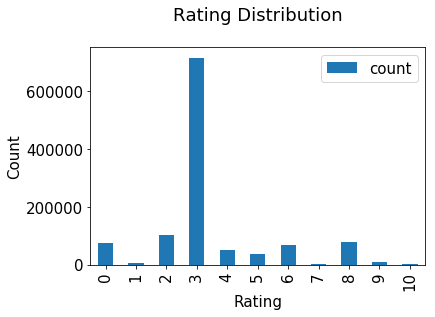

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", size=15)
p_ratings.plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [49]:
users.show()

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|NULL|
|      2|stockton, califor...|  18|
|      3|moscow, yukon ter...|NULL|
|      4|porto, v.n.gaia, ...|  17|
|      5|farnborough, hant...|NULL|
|      6|santa monica, cal...|  61|
|      7| washington, dc, usa|NULL|
|      8|timmins, ontario,...|NULL|
|      9|germantown, tenne...|NULL|
|     10|albacete, wiscons...|  26|
|     11|melbourne, victor...|  14|
|     12|fort bragg, calif...|NULL|
|     13|barcelona, barcel...|  26|
|     14|mediapolis, iowa,...|NULL|
|     15|calgary, alberta,...|NULL|
|     16|albuquerque, new ...|NULL|
|     17|chesapeake, virgi...|NULL|
|     18|rio de janeiro, r...|  25|
|     19|           weston, ,|  14|
|     20|langhorne, pennsy...|  19|
+-------+--------------------+----+
only showing top 20 rows



In [57]:
p_ages=users.groupBy("Age").count().toPandas()
print(p_ages)

      Age   count
0      51    2203
1       7      27
2     124       5
3      54    2140
4      15    2383
5     132       1
6     200       2
7      11     121
8     101       7
9     138       1
10     29    5293
11     69     373
12     42    2758
13     73     200
14     87       6
15     64     680
16      3      45
17     30    4778
18    113       2
19     34    4656
20    133       2
21     59    1205
22    162       1
23    146       1
24      8      54
25     28    5347
26     22    4714
27    199       2
28     85      17
29     35    4194
..    ...     ...
137    65     593
138     4      28
139    39    3234
140   210       3
141    62     882
142    12     192
143    83      24
144   123       8
145   109       1
146    13     885
147   157       1
148    14    1962
149    21    4438
150    66     545
151    91      13
152    94       5
153   175       1
154    72     223
155    74     170
156   137       1
157   151       2
158    76     114
159     2     105
160  NULL 

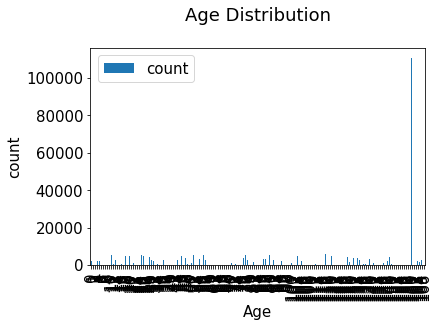

In [59]:
#users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
p_ages.plot(kind='bar')
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()